In [1]:
import numpy as np
import pandas as pd

## Load Corpus

In [2]:
df = pd.read_csv('bbc-text.csv')

In [3]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

## Get Tokens & Text Features

In [5]:
import nltk

In [6]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer

Split off the text title

Tokenize sentences

In [7]:
df['tokens'] = df['text'].apply(word_tokenize)

In [8]:
ps = PorterStemmer()

Strip out numbers and stem words

In [9]:
df['clean_text'] =  df['tokens'].apply(lambda x: " ".join([ps.stem(i) for i in x if not i.isdigit()]))

Sentence level tokenization

In [10]:
df['sentences'] = df['clean_text'].apply(sent_tokenize)

In [11]:
df['n_sentences'] = df['sentences'].apply(lambda x: len(x))

In [12]:
df['n_sentences'].plot.hist();

In [13]:
df = df[df['n_sentences']<51].copy()

In [14]:
df['max_sen_length'] = df['sentences'].apply(lambda x: max([len(word_tokenize(i)) for i in x]))

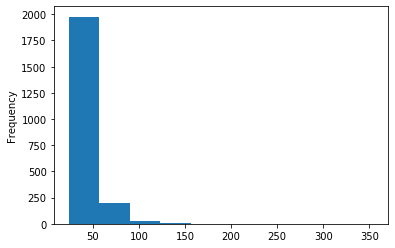

In [15]:
df['max_sen_length'].plot.hist();

In [16]:
df = df[df['max_sen_length']<101].copy()

In [17]:
df['text_length'] = df['clean_text'].apply(lambda x: len(word_tokenize(x)))

We will need theses properties to use as matrices dimensions in the network

In [18]:
MAX_TEXT_LENGTH = df['text_length'].max()

In [19]:
MAX_NUM_SENTS = df['n_sentences'].max()

In [20]:
MAX_SEN_LENGTH = df['max_sen_length'].max()

In [21]:
print('Max text length in words: {}\nMax sent length in words: {}\nMax No sentences: {}'
      .format(MAX_TEXT_LENGTH, MAX_SEN_LENGTH, MAX_NUM_SENTS))

Max text length in words: 1699
Max sent length in words: 100
Max No sentences: 49


Pad the sentences for use in the attention network

In [22]:
df['pad_sentences'] = df['sentences'].apply(lambda x: x + ([''] * (MAX_NUM_SENTS-len(x))))

### Labels

In [23]:
from sklearn.preprocessing import LabelBinarizer

In [24]:
one_hot = LabelBinarizer()

In [25]:
oh_labels = one_hot.fit_transform(df['category'])

In [26]:
N_LABELS = oh_labels.shape[1]

In [27]:
one_hot.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype='<U13')

## Attention Network

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [29]:
NUM_WORDS = 10000

In [30]:
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(df['text'])

In [31]:
top_words = sorted(tokenizer.word_counts.items(), key=lambda x: x[1])[::-1][:NUM_WORDS]

### Import GLOVE Embeddings

In [32]:
embeddings_index = {}

with open('glove.6B.100d.txt') as f: 
    for line in f:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

In [33]:
embedding_matrix = np.zeros((NUM_WORDS+1, 100))

for word, idx in list(tokenizer.word_index.items())[:NUM_WORDS]:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [34]:
embedding_matrix.shape

(10001, 100)

### Data Processing

In [35]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

Build an data-set in the format DOCUMENTS x SENTENCES x WORDS

In [36]:
def text_processer(raw_texts, maxlen=100):
    tokens = tokenizer.texts_to_sequences(raw_texts)
    return pad_sequences(tokens, maxlen=maxlen)

In [37]:
sen_data = np.stack(df['pad_sentences'].apply(lambda x: text_processer(x, MAX_SEN_LENGTH)).values)

In [38]:
sen_data.shape

(2185, 49, 100)

## Network

In [39]:
import tensorflow.keras.backend as K
from tensorflow import Variable
from tensorflow.keras.layers import Layer, GRU, TimeDistributed, Bidirectional, Dense, Embedding
from tensorflow.keras import initializers, Sequential

In [40]:
txt_train, txt_test, x_train, x_test, y_train, y_test = train_test_split(df['clean_text'].values, sen_data, oh_labels)

This network code was adapted from https://github.com/richliao/textClassifier

In [41]:
class AttLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = Variable(self.init((input_shape[-1], self.attention_dim)), trainable=True)
        self.b = Variable(self.init((self.attention_dim, )), trainable=True)
        self.u = Variable(self.init((self.attention_dim, 1)), trainable=True)
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            ait *= K.cast(mask, K.floatx())
        
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [42]:
MAX_SEN_LENGTH = 100

In [43]:
embedding_layer = Embedding(NUM_WORDS+1, 
                            100,
                            weights = [embedding_matrix],
                            input_length = MAX_SEN_LENGTH,
                            trainable = False, 
                            name = 'glove_embedding')

In [44]:
sentEncoder = Sequential()
sentEncoder.add(embedding_layer)
sentEncoder.add(Bidirectional(GRU(50, return_sequences=True)))
sentEncoder.add(AttLayer(50))

In [45]:
model = Sequential()
model.add(TimeDistributed(sentEncoder, input_shape=(MAX_NUM_SENTS, MAX_SEN_LENGTH)))
model.add(Bidirectional(GRU(50, return_sequences=True)))
model.add(AttLayer(50))
model.add(Dense(N_LABELS, activation='sigmoid'))

In [46]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [47]:
sentEncoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
glove_embedding (Embedding)  (None, 100, 100)          1000100   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 100)          45600     
_________________________________________________________________
att_layer (AttLayer)         (None, 100)               5100      
Total params: 1,050,800
Trainable params: 50,700
Non-trainable params: 1,000,100
_________________________________________________________________


In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 49, 100)           1050800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 49, 100)           45600     
_________________________________________________________________
att_layer_1 (AttLayer)       (None, 100)               5100      
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
Total params: 1,102,005
Trainable params: 101,905
Non-trainable params: 1,000,100
_________________________________________________________________


In [49]:
model.fit(x_train, y_train, 
          validation_data=(x_test, y_test), 
          epochs=10, batch_size=10)

Train on 1638 samples, validate on 547 samples
Epoch 1/10
1638/1638 [==============================] - 22s 14ms/sample - loss: 0.3539 - acc: 0.8546 - val_loss: 0.1797 - val_acc: 0.9287
Epoch 2/10
1638/1638 [==============================] - 13s 8ms/sample - loss: 0.1053 - acc: 0.9658 - val_loss: 0.0676 - val_acc: 0.9773
Epoch 3/10
1638/1638 [==============================] - 13s 8ms/sample - loss: 0.0668 - acc: 0.9774 - val_loss: 0.0482 - val_acc: 0.9821
Epoch 4/10
1638/1638 [==============================] - 13s 8ms/sample - loss: 0.0507 - acc: 0.9819 - val_loss: 0.0431 - val_acc: 0.9843
Epoch 5/10
1638/1638 [==============================] - 13s 8ms/sample - loss: 0.0388 - acc: 0.9873 - val_loss: 0.0560 - val_acc: 0.9839
Epoch 6/10
1638/1638 [==============================] - 13s 8ms/sample - loss: 0.0311 - acc: 0.9891 - val_loss: 0.0496 - val_acc: 0.9799
Epoch 7/10
1638/1638 [==============================] - 14s 8ms/sample - loss: 0.0257 - acc: 0.9905 - val_loss: 0.0405 - val_acc: 

In [51]:
def test_example(n):
    p = model.predict(x_test[n:n+1])[0]
    top = sorted(list(zip(one_hot.classes_, p)), key=lambda x: x[1], reverse=True)
    print(txt_test[n],'\n')
    print('Tagged as:', one_hot.classes_[np.nonzero(y_test[n])],'\n')
    for i in top[:4]:
        print("{:25}:{:03.4f}".format(i[0], i[1]))
        
    print('=========')

In [143]:
test_example(10)

bush budget seek deep cutback presid bush ha present hi budget cut domest spend in a bid to lower a record deficit project to peak at $ 427bn ( £230bn ) thi year . the $ 2.58 trillion ( £1.38 trillion ) budget submit to congress affect domest programm from farm to the environ educ and health . but foreign aid is due to rise by % with more money to treat hiv/aid and reward econom and polit reform . militari spend is also set to rise by 4.8 % to reach $ 419.3bn . the budget doe not includ the cost of run militari oper in iraq and afghanistan for which the administr is expect to seek an extra $ 80bn from congress later thi year . congress will spend sever month debat georg w bush s propos . the state depart s plan budget would rise to just under $ 23bn - a fraction of the defenc depart s request - includ almost $ 6bn to assist us alli in the war on terror . howev the administr is keen to highlight it global effort to tackl hiv/aid the bbc s jonathan beal report and plan spend would almost

### Attention Extraction

In [113]:
from tensorflow.keras import Model
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [121]:
hidden_out_model = Model(sentEncoder.input, sentEncoder.layers[1].output)
word_ctx_0 = sentEncoder.layers[-1].get_weights()[0]
word_ctx_1 = sentEncoder.layers[-1].get_weights()[1]
word_ctx_2 = sentEncoder.layers[-1].get_weights()[2]

def word_importance(n):
    """Extract tokens and corresponding attention weight from an indexed test message"""
    example = x_test[n]
    example = example[~np.all(example == 0, axis=1)]
    word_enc = hidden_out_model.predict(example)
    
    u_watt = np.exp(np.dot(np.tanh(np.dot(word_enc, word_ctx_0)+word_ctx_1), word_ctx_2)[:,:,0])
    u_watt = normalize(u_watt, axis=1, norm='l2')
    
    wrd_wts = []
    
    for i, j in enumerate(example):
        wrds = np.trim_zeros(j)
        toks = ([tokenizer.sequences_to_texts([wrds[k:k+1]])[0] for k in range(wrds.shape[0])])
        wrd_wts.append([toks, u_watt[i, -len(toks):]])
    
    return wrd_wts

In [141]:
def plot_attention(n):
    """Plot a bar chart of normalized attention weights with corresponding text labels"""
    wts = word_importance(n)
    r = list(range(max([len(i[0]) for i in wts])))
    
    f, ax = plt.subplots(len(wts), sharex=True, sharey=True, figsize=(15, 3*len(wts)))
    
    if len(wts) > 1:
        for i, j in enumerate(wts):
            rects = ax[i].bar(r, j[1].tolist()+[0 for _ in range(len(r)-j[1].shape[0])], color='0.8')
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            for k, l in enumerate(j[0]):
                ax[i].text(rects[k].get_x() + rects[k].get_width()/2., 0.5, l, ha='center', va='bottom', rotation=90)
    
    else:
        for i, j in enumerate(wts):
            rects = ax.bar(r, j[1].tolist()+[0 for _ in range(len(r)-j[1].shape[0])], color='0.8')
            ax.set_xticks([])
            ax.set_yticks([])
            for k, l in enumerate(j[0]):
                ax.text(rects[k].get_x() + rects[k].get_width()/2., 0.5, l, ha='center', va='bottom')
    
    plt.show()

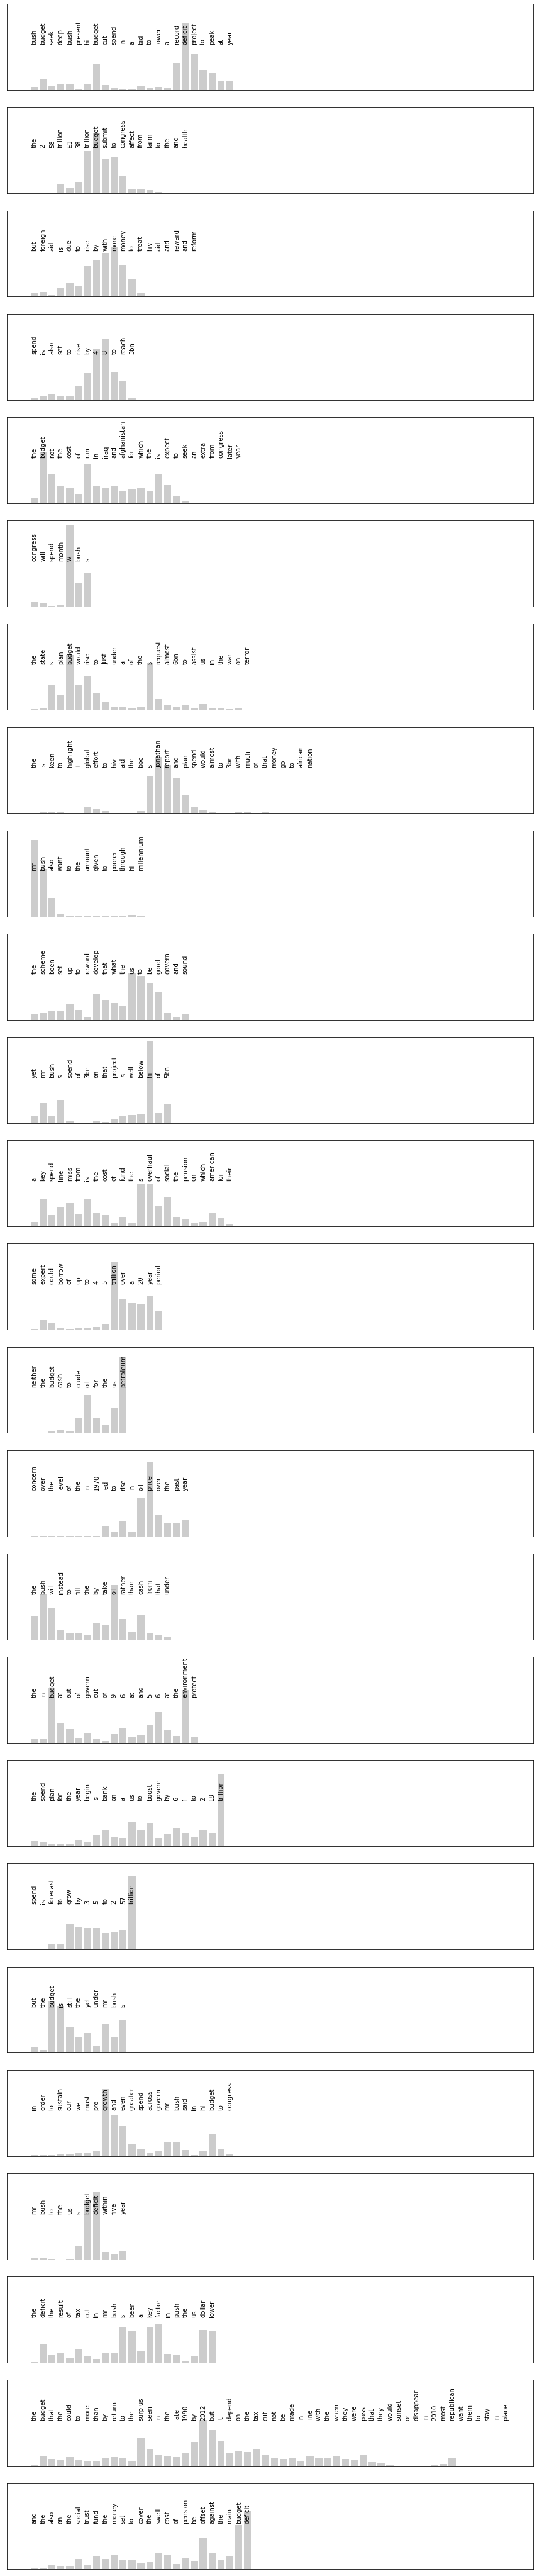

In [142]:
plot_attention(10)